LOSS train 0.8244410295341087 valid 0.8108338731325279 for epoch 2
LOSS train 0.6623952729231108 valid 0.6351904159310061 for epoch 1
LOSS train 0.5640904464374827 valid 0.5604335769709277 for epoch 1


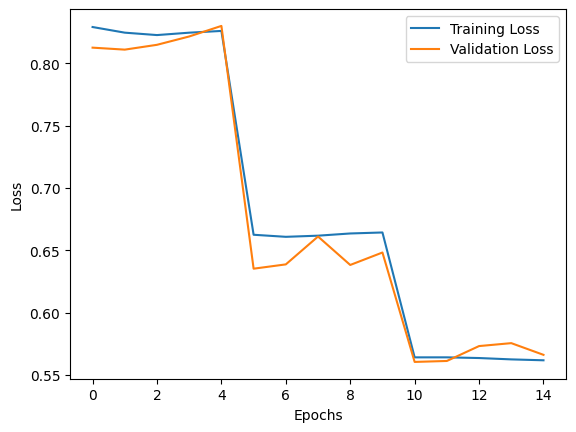

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

weather_data = np.load('weather.npz')['data']
traffic_data = np.load('traffic.npz')['data']

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

def train_epoch(model, train_loader, loss_function, optimizer):
    total_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / (i + 1)
    return avg_loss

def run_rnn_model(model, weather_data, traffic_data, loss_function, optimizer, num_epochs):
    best_params = []
    train_losses = []
    valid_losses = []

    for i in range(traffic_data.shape[2]):
        y = traffic_data[:, :, i]
        y_n = (y - y.mean()) / (y.std())
        y_n = torch.from_numpy(y_n).float()

        X = torch.from_numpy(weather_data[:, 0]).float()
        X = X.unsqueeze(-1)

        train_X, test_X, train_y, test_y = train_test_split(X, y_n)

        training_dataset = TensorDataset(train_X, train_y)
        testing_dataset = TensorDataset(test_X, test_y)

        train_loader = DataLoader(training_dataset, shuffle=True)
        test_loader = DataLoader(testing_dataset, shuffle=True)

        best_loss = 1000
        best_tloss = 1000
        best_epoch = -1

        for epoch in range(1, num_epochs + 1):
            model.train(True)
            avg_loss = train_epoch(model, train_loader, loss_function, optimizer)
            model.train(False)

            train_losses.append(avg_loss)

            total_tloss = 0.0
            for i, data in enumerate(test_loader):
                inputs, labels = data
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                total_tloss += loss.item()
            avg_tloss = total_tloss / (i + 1)

            valid_losses.append(avg_tloss)

            if avg_tloss < best_tloss:
                best_loss = avg_loss
                best_tloss = avg_tloss
                best_epoch = epoch

        print(f'LOSS train {best_loss} valid {best_tloss} for epoch {best_epoch}')
        best_params.append([best_loss, best_tloss, best_epoch])

    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return best_params

#model params
input_size = 1
hidden_size = 32
output_size = 1
num_layers = 1
num_epochs = 5

# instantiate model, loss function and optimizer
rnn_model = SimpleRNN(input_size, hidden_size, output_size, num_layers)
loss_function = nn.L1Loss()
optimizer = SGD(rnn_model.parameters(), lr=0.1)

#train
best_params = run_rnn_model(rnn_model, weather_data, traffic_data, loss_function, optimizer, num_epochs)

In [ ]:
for params in 